# Estimating nuisance parameters in inverse problems

Based on 

* [Estimating nuisance parameters in inverse problems](https://iopscience.iop.org/article/10.1088/0266-5611/28/11/115016).
A.Y. Aravkin and T. van Leeuwen. Inverse Problems (28:11)

* [Variable Projection for NonSmooth Problems](https://epubs.siam.org/doi/abs/10.1137/20M1348650). T. van Leeuwen and A.Y. Aravkin. SIAM J. Sci. Comput. (accepted)

(Motivation)

# Overview

* General formulation
* Variable projection
* Examples
* Wrap-up

# General formulation

MAP estimation for inverse problems can be generally formulated as 

$$\min_u F(u) + G(u),$$

with $F(u) = -\log \pi_{\text{data}}(u)$ and  $G(u) = -\log \pi_{\text{prior}}(u)$.

The densities often include parameters $\theta$ (mean, variance, ...). This leads to 

$$\min_{u,\theta} F(u,\theta) + G(u,\theta) + H(\theta),$$

with $H(\theta) = -\log \pi_{\text{hyper}}(\theta)$.

> **Example: *Extended least-squares:***
> $$\min_{u,\Sigma} m \log |\Sigma| + \sum_{i=1}^m \|K(u) - f^\delta\|_{\Sigma^{-1}}^2.$$
> Has a closed-form solution for fixed $u$:
> $$\Sigma = \frac{1}{m}\sum_{i}^m (K(u) - f^\delta)(K(u) - f^\delta)^T.$$

> **Example: *Robust data-fitting:***
> $$\min_{u,\sigma^2} n\log\sigma + \sum_{i=1}^n \log\left(1 + \frac{r_i(u)^2}{\sigma^2}\right), \quad r = K(u) - f.$$

# Variable projection


Often, the nuisance parameters separate, and we can write

$$\min_u \underbrace{\min_\alpha F(u,\alpha)}_{\overline{F}(u)} + \underbrace{\min_\beta G(u,\beta)}_{\overline{G}(u)}.$$

and apply a proximal-gradient algorithm

$$u_{k+1} = \text{prox}_{\lambda \overline{G}} \left(u_k - \lambda \nabla \overline{F}(u)\right).$$


## Derivative formula
Assuming that $\nabla_u F$ and $\nabla_\alpha F$ are Lipschitz-continuous and $F$ is $\mu-$ strongly convex in $\alpha$ for all $u$;


* $\overline{\alpha}(u) = \text{arg}\min_\alpha F(u,\alpha)$ is Lipschitz continuous 
* $\nabla \overline{F}(u) = \left.\nabla_u F(u,\alpha)\right|_{\alpha = \overline{\alpha}(u)}.$
* an approximate minimiser $\widetilde{\alpha}(u)$ yields an approximate gradient with

$$\|\nabla F(u,\overline{\alpha}(u)) - \nabla F(u,\widetilde{\alpha}(u))\| \leq L_{u\alpha} \|\overline{\alpha}(u) -\widetilde{\alpha}(u)\|.$$

## Proximal operator

## Convergence results

(Schmidt, Mark, Nicolas Le Roux, and Francis Bach. "Convergence rates of inexact proximal-gradient methods for convex optimization." NeurIps (2011).)

# Examples

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.restoration import wiener, richardson_lucy, denoise_tv_chambolle
from scipy.fft import fft2, ifft2
from scipy.optimize import minimize

## Tikhonov regularisation

Given $K \in \mathbb{R}^{m\times n}$,

$$\min_{u,\alpha,\beta} \alpha \|Ku - f^\delta\|_2^2 + \beta \|Lu\|_2^2 - m \log \alpha - n\log\beta.$$

* $\overline{\alpha}(u) = m/ \|Ku - f^\delta\|_2^2$, $\overline{\beta}(u) = n/ \|Lu\|_2^2.$

![](./figures/tikhonov1.png)

## Compressed sensing

## Total variation regularisation

In [157]:
def K(inp,psf=[],mode='forward'):
    n = inp.shape[0]
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp)
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
    if mode == 'inv':
        outp = ifft2( np.conj(k_hat) * inp_hat / ( np.conj(k_hat) * k_hat ) )
        
    return np.real(outp)

def TV_decon(f, psf, alpha, lmbda, maxit = 100, tol=1e-3):
    """
    TV deconvolution, solves: 
        
        min_u 0.5*\alpha*\|Ku - f\|_2^2 + TV(u)
    
    using a proximal gradient method.
    
    input:
        f     - data, 2D array
        psf   - psf to define forward operator K, 2D array
        alpha - regularisation parameter, float
        lmbda - stepsize for proximal gradient method, float
        maxit - max. iteration count (default 100), integer
        tol   - stopping tolerance (default 1e-3), float
    
    output:
        u    - result, 2D array
        hist - convergence history \|u_{k} - u_{k-1}\|, 1D array
    """
    n = f.shape[0]*f.shape[1]
    u = np.zeros(f.shape)
    converged = False
    hist = []
    it = 0
    while not converged:
        r = K(u,psf,mode='forward') - f
        if not alpha:
            alpha = n/np.linalg.norm(r)**2
        g = alpha*K(r,psf,mode='adjoint')
        v = u - lmbda*g
        up = denoise_tv_chambolle(v, weight = lmbda, eps=1e-6, n_iter_max=5000)
        
        du = np.linalg.norm(u - up)
        it += 1
        
        converged = (du <= tol) or (it >= maxit)
        hist.append(du)
        u = up
    return u, np.array(hist)

def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)

In [165]:
## settings
n = 20
sigma = 1e-2
psf = np.ones((3,3)) / 9
                
# ground truth and data
u = np.float32(data.binary_blobs(n))
f_delta = K(u,psf=psf) + sigma*np.random.randn(n,n)

In [166]:
# reconstruct
alpha = 1e2
lmbda = 1e-2
maxit = 2000
u_est, hist = TV_decon(f_delta, psf, alpha, lmbda, maxit)

print('|Ku - f|/sqrt(n) =', np.linalg.norm(K(u_est,psf=psf) - f_delta)/np.sqrt(n))

|Ku - f|/sqrt(n) = 0.15757198985192972


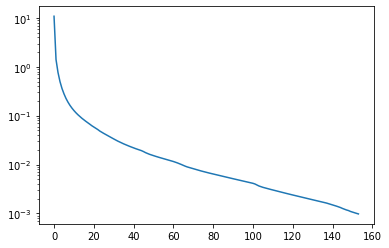

In [170]:
plt.semilogy(hist)

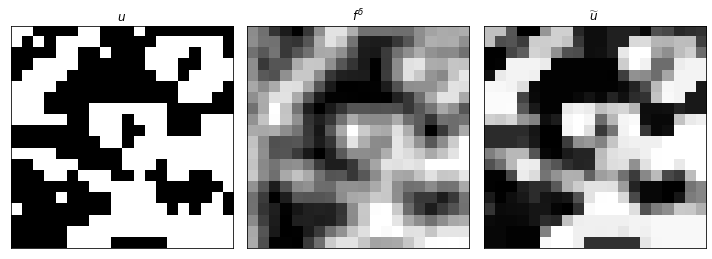

In [167]:
# plot
plot_images([u, f_delta,u_est], [r'$u$', r'$f^\delta$',r'$\widetilde{u}$'])

## Robust data-fitting

## Graphical lasso

# Wrap-up

* ...
* ...